In [1]:
import pvl
import struct
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
import binascii

In [2]:
lo_file = '/home/arsanders/testData/lo/reimport/input/3133_h1.pds.img'

In [3]:
header = pvl.load(lo_file)

In [4]:
header

PVLModule([
  ('PDS_VERSION_ID', 'PDS3')
  ('RECORD_TYPE', 'FIXED_LENGTH')
  ('RECORD_BYTES', 604)
  ('FILE_RECORDS', 162)
  ('LABEL_RECORDS', 11)
  ('INTERCHANGE_FORMAT', 'BINARY')
  ('^IMAGE', 12)
  ('DATA_SET_ID', 'LO-L-LO3/4/5-4-CDR-V1.0')
  ('PRODUCT_ID', '3133_H1')
  ('ORIGINAL_PRODUCT_ID', '3133H')
  ('PRODUCT_TYPE', 'CDR')
  ('MISSION_NAME', 'LUNAR ORBITER')
  ('SPACECRAFT_NAME', 'LUNAR_ORBITER_3')
  ('INSTRUMENT_NAME', '24_INCH_FOCAL_LENGTH_CAMERA')
  ('INSTRUMENT_ID', '24INCH_FLC')
  ('TARGET_NAME', 'MOON')
  ('START_TIME',
   datetime.datetime(1967, 2, 20, 8, 14, 28, 610000, tzinfo=datetime.timezone.utc))
  ('IMAGE_NUMBER',
   ['313312921',
    '313312930',
    '313312941',
    '313312950',
    '313312961',
    '313312970',
    '313312990',
    '313313000',
    '313313010',
    '313313020',
    '313313030',
    '313313040',
    '313313051',
    '313313060',
    '313313070',
    '313313090',
    '313313100',
    '313313110',
    '313313120',
    '313313130',
    '313313140',


In [5]:
with open(lo_file, 'rb') as f:
    image_offset = (header["^IMAGE"]-1)* header["RECORD_BYTES"]
    f.seek(image_offset)
    b_image_data = f.read()

In [6]:
n_lines = 5
line_length = header['IMAGE']['LINE_SAMPLES'] * (header['IMAGE']['SAMPLE_BITS']//8)

In [7]:
image_data = []
for j in range(n_lines):
    image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length], dtype=np.float32, count=int(line_length)//4)
    image_data.append(image_sample)
image_data = np.array(image_data)

In [8]:
image_data.shape

(5, 151)

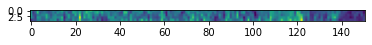

In [9]:
plt.imshow(image_data)

In [10]:
class RealIsisCubeLabelEncoder(pvl.encoder.ISISEncoder):    
    def encode_time(self, value):
        if value.microsecond:
            second = u'%02d.%06d' % (value.second, value.microsecond)
        else:
            second = u'%02d' % value.second

        time = u'%02d:%02d:%s' % (value.hour, value.minute, second)
        return time

In [14]:
image_fn, image_ext = os.path.splitext(lo_file)
crop = '_cropped'
mini_image_fn = image_fn + crop + image_ext
mini_image_bn = os.path.basename(mini_image_fn)

grammar = pvl.grammar.ISISGrammar()
grammar.comments+=(("#", "\n"), )
encoder = RealIsisCubeLabelEncoder()

# Overwrite the number of lines in the label
header['IMAGE']['LINES'] = n_lines

# Calculate the new offset
header['^IMAGE'] = pvl.collections.Units(len(pvl.dumps(header, encoder=encoder, grammar=grammar)), 'BYTES')

In [15]:
header

PVLModule([
  ('PDS_VERSION_ID', 'PDS3')
  ('RECORD_TYPE', 'FIXED_LENGTH')
  ('RECORD_BYTES', 604)
  ('FILE_RECORDS', 162)
  ('LABEL_RECORDS', 11)
  ('INTERCHANGE_FORMAT', 'BINARY')
  ('^IMAGE', Units(value=5230, units='BYTES'))
  ('DATA_SET_ID', 'LO-L-LO3/4/5-4-CDR-V1.0')
  ('PRODUCT_ID', '3133_H1')
  ('ORIGINAL_PRODUCT_ID', '3133H')
  ('PRODUCT_TYPE', 'CDR')
  ('MISSION_NAME', 'LUNAR ORBITER')
  ('SPACECRAFT_NAME', 'LUNAR_ORBITER_3')
  ('INSTRUMENT_NAME', '24_INCH_FOCAL_LENGTH_CAMERA')
  ('INSTRUMENT_ID', '24INCH_FLC')
  ('TARGET_NAME', 'MOON')
  ('START_TIME',
   datetime.datetime(1967, 2, 20, 8, 14, 28, 610000, tzinfo=datetime.timezone.utc))
  ('IMAGE_NUMBER',
   ['313312921',
    '313312930',
    '313312941',
    '313312950',
    '313312961',
    '313312970',
    '313312990',
    '313313000',
    '313313010',
    '313313020',
    '313313030',
    '313313040',
    '313313051',
    '313313060',
    '313313070',
    '313313090',
    '313313100',
    '313313110',
    '313313120',
    

In [17]:
label_fn, label_ext = os.path.splitext(lo_file)
out_label = label_fn + crop + label_ext

pvl.dump(header, out_label, encoder=encoder, grammar=grammar)
pvl.dumps(header, encoder=encoder, grammar=grammar)

'PDS_VERSION_ID                          = PDS3\nRECORD_TYPE                             = FIXED_LENGTH\nRECORD_BYTES                            = 604\nFILE_RECORDS                            = 162\nLABEL_RECORDS                           = 11\nINTERCHANGE_FORMAT                      = BINARY\n^IMAGE                                  = 5230 <BYTES>\nDATA_SET_ID                             = LO-L-LO3/4/5-4-CDR-V1.0\nPRODUCT_ID                              = 3133_H1\nORIGINAL_PRODUCT_ID                     = 3133H\nPRODUCT_TYPE                            = CDR\nMISSION_NAME                            = "LUNAR ORBITER"\nSPACECRAFT_NAME                         = LUNAR_ORBITER_3\nINSTRUMENT_NAME                         = 24_INCH_FOCAL_LENGTH_CAMERA\nINSTRUMENT_ID                           = 24INCH_FLC\nTARGET_NAME                             = MOON\nSTART_TIME                              = 1967-02-20T08:14:28.610000\nIMAGE_NUMBER = ("313312921", "313312930", "313312941", "313312950",\n     

In [18]:
with open(mini_image_fn, 'ab+') as f:
    b_reduced_image_data = image_data.tobytes()
    f.seek(0, 2)
    f.write(b'\n')
    f.write(b_reduced_image_data)